In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("/content/smart_grid_stability_augmented.csv")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


The dataset contains several variables that are likely related to the characteristics of a smart grid system.

* **tau1, tau2, tau3, tau4:** These columns could represent time constants related to different components or areas within the grid.
* **p1, p2, p3, p4:** These might be power measurements or demands at four different points or sectors in the grid.
* **g1, g2, g3, g4:** These could be generation capacities or some form of efficiency parameters for generators at four locations.
* **stab:** A numerical stability indicator, possibly a calculated stability metric.
* **stabf:** A categorical stability indicator with values 'stable' or 'unstable'.

There is a direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' will be dropped and 'stabf' will remain as the sole dependent variable

# Summary Statistics and Missing Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


In [ ]:
df.isnull().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [ ]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


**Summary Statistics:**

* The variables **tau1, tau2, tau3, tau4, g1, g2, g3**, and **g4** have a mean value around **5.25** and **0.525**, respectively, with their distributions spanning a similar range which suggests a uniform distribution across these parameters.
* The power variables **p1, p2, p3**, and **p4** show that **p1** has a positive mean **(3.75)** indicating it might be a supply point, whereas **p2, p3**, and **p4** have negative means **(-1.25)** suggesting they are demand points. Their standard deviations are relatively small, indicating that the values do not vary widely from the mean.
* The **stab** variable, which appears to be a numerical stability indicator, has a mean close to **0.0157**, with a minimum and maximum value indicating a range of stability conditions in the grid.

# Analysis of Distributions and Correlations

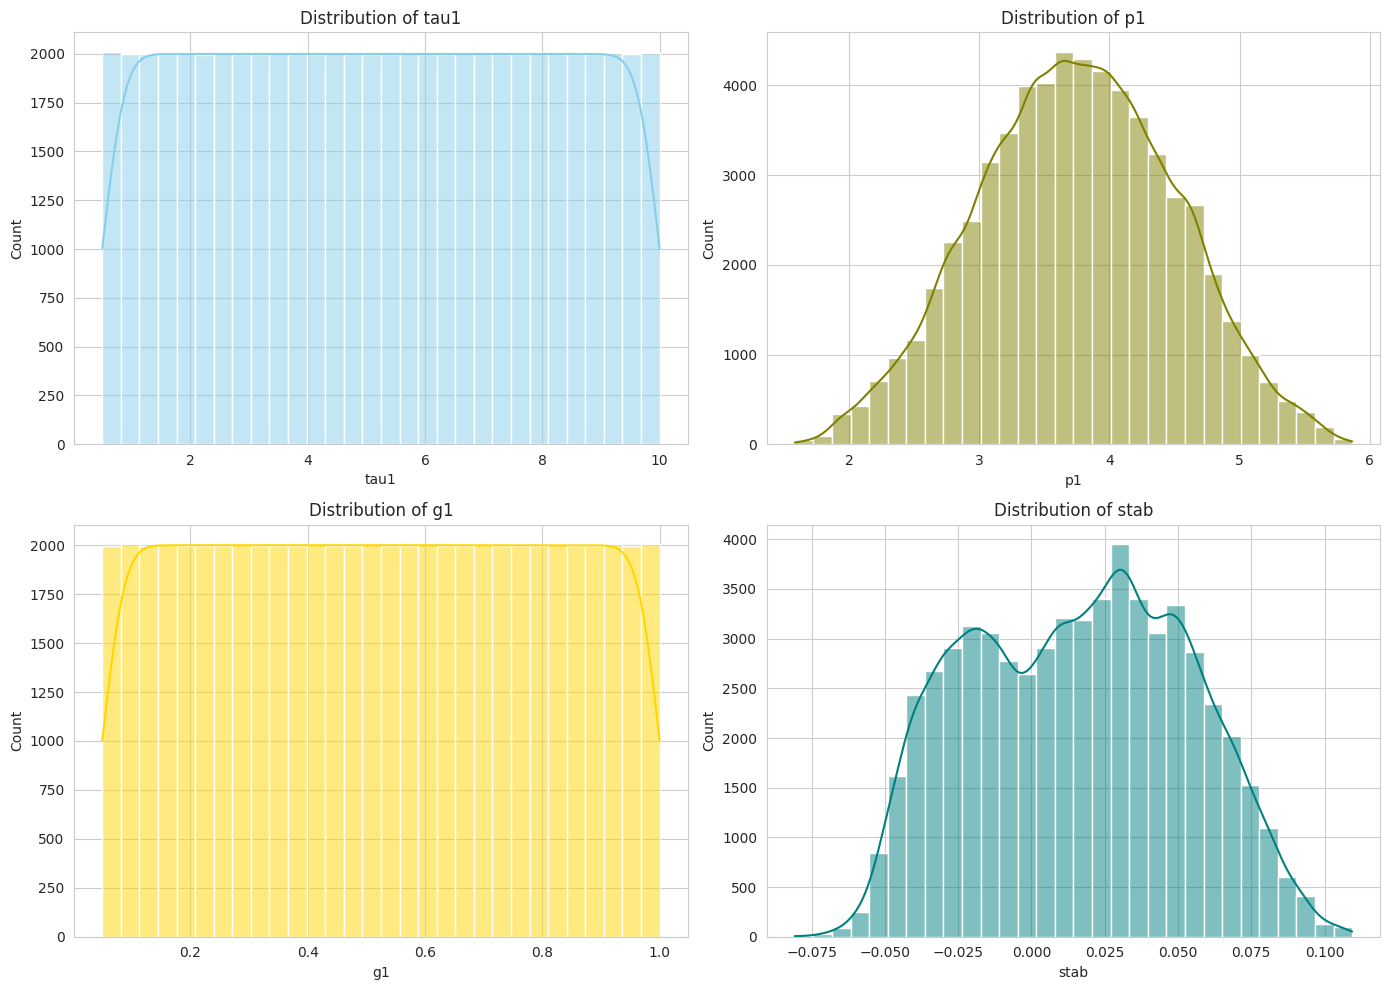

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df['tau1'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
sns.histplot(df['p1'], bins=30, kde=True, ax=axes[0, 1], color='olive')
sns.histplot(df['g1'], bins=30, kde=True, ax=axes[1, 0], color='gold')
sns.histplot(df['stab'], bins=30, kde=True, ax=axes[1, 1], color='teal')

axes[0, 0].set_title('Distribution of tau1')
axes[0, 1].set_title('Distribution of p1')
axes[1, 0].set_title('Distribution of g1')
axes[1, 1].set_title('Distribution of stab')

plt.tight_layout()
plt.show()

**Distributions:**

* **tau1, g1, and stab:** The distributions of **tau1, g1**, and **stab** suggest a relatively uniform distribution for **tau1** and **g1**, indicating that these parameters are spread evenly across their range. The stability metric stab shows a distribution that is slightly skewed, but it also appears to cover a broad range of values.
* **p1:** The distribution of **p1** shows variability in power generation/demand, with a peak indicating a common value range but with the distribution covering both supply and demand ranges.

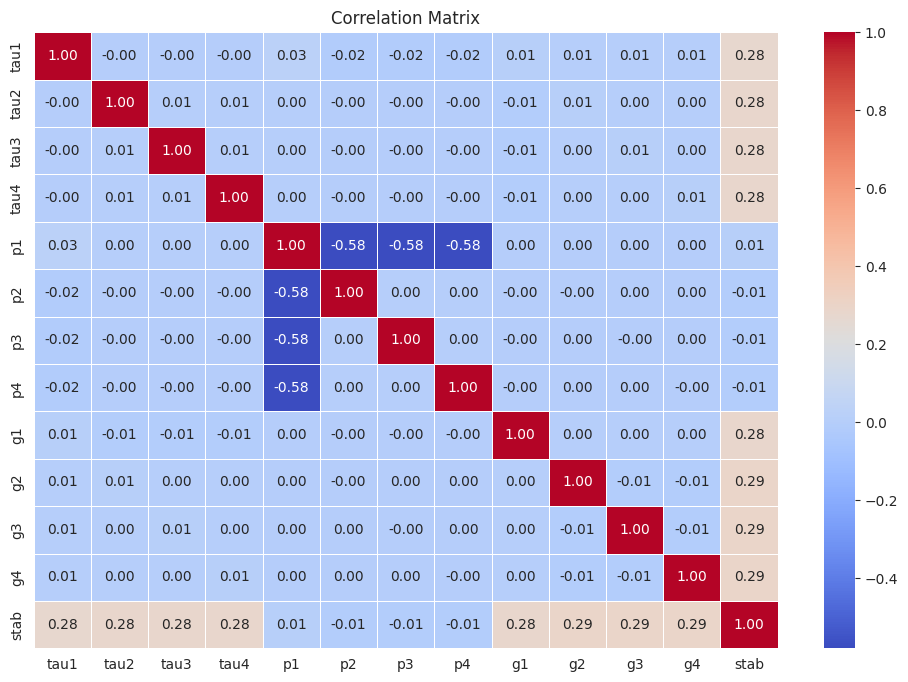

Correlation with 'stab':
 stab    1.000000
g3      0.293684
g2      0.293684
g4      0.293684
tau4    0.283417
tau2    0.283417
tau3    0.283417
g1      0.282774
tau1    0.275761
p1      0.010278
p2     -0.005951
p3     -0.005951
p4     -0.005951
Name: stab, dtype: float64


In [ ]:
# Select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

correlation_with_stab = correlation_matrix['stab'].sort_values(ascending=False)
print("Correlation with 'stab':\n", correlation_with_stab)


In [ ]:
class_distribution = df['stabf'].value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
unstable    38280
stable      21720
Name: stabf, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Load your dataset
df = pd.read_csv("/content/smart_grid_stability.csv")
df['stabf_encoded'] = LabelEncoder().fit_transform(df['stabf'])
X = df.drop(['stabf', 'stabf_encoded', 'stab'], axis=1)
y = df['stabf_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_learners = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

# Initialize the Stacking Classifier with Logistic Regression as the final estimator
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=3)

# Fit the model on the training data
clf.fit(X_train, y_train)


In [ ]:

base_learners = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

# Initialize the Stacking Classifier with Logistic Regression as the final estimator
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=3)

# Fit the model on the training data
clf.fit(X_train, y_train)


StackingClassifier(cv=3,
                   estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              fe...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

Accuracy: 0.9799
Classification Report:
              precision    recall  f1-score   support

      stable       0.97      0.97      0.97      4322
    unstable       0.98      0.99      0.98      7678

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



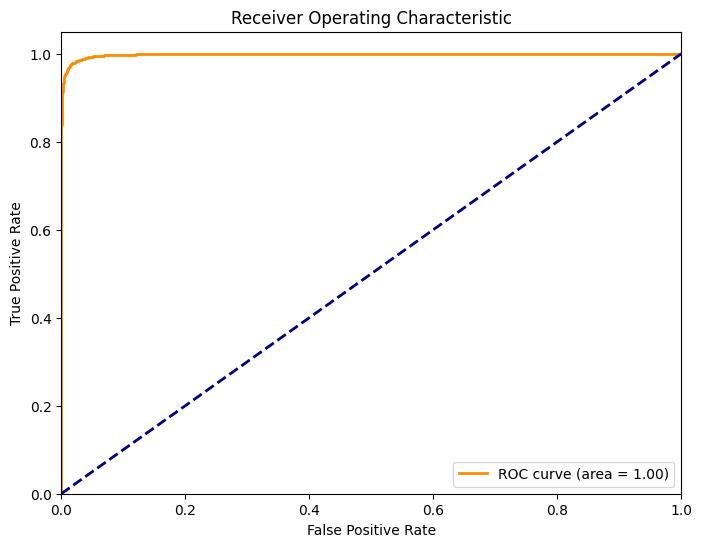

In [ ]:
# Predict probabilities for the test set
y_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Print classification report and accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["stable", "unstable"]))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


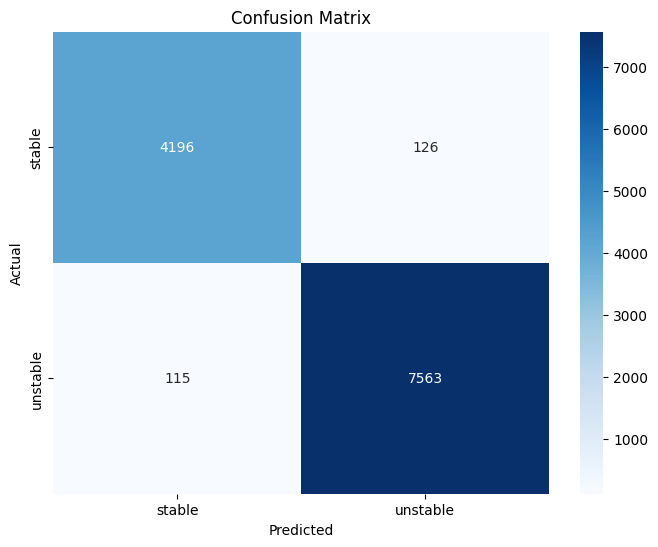

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["stable", "unstable"], yticklabels=["stable", "unstable"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/100
1200/1200 [==============================] - 63s 5ms/step - loss: 0.3770 - accuracy: 0.8274 - val_loss: 0.1990 - val_accuracy: 0.9210
Epoch 2/100
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2826 - accuracy: 0.8752 - val_loss: 0.1657 - val_accuracy: 0.9395
Epoch 3/100
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2523 - accuracy: 0.8910 - val_loss: 0.1535 - val_accuracy: 0.9411
Epoch 4/100
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2386 - accuracy: 0.8965 - val_loss: 0.1403 - val_accuracy: 0.9524
Epoch 5/100
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2210 - accuracy: 0.9046 - val_loss: 0.1258 - val_accuracy: 0.9535
Epoch 6/100
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2116 - accuracy: 0.9108 - val_loss: 0.1241 - val_accuracy: 0.9580
Epoch 7/100
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2075 - accuracy: 0.9107 - val_loss: 0.1160 - val_a

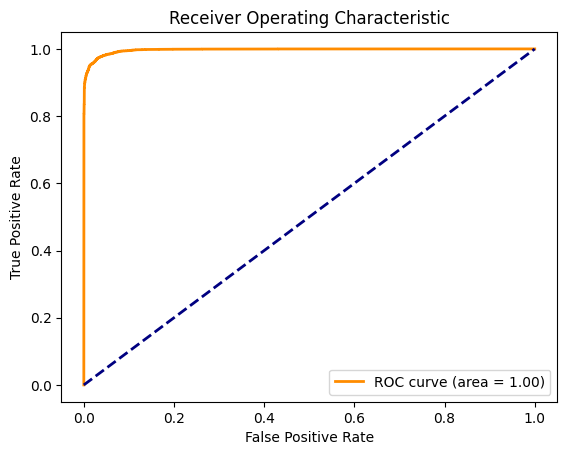

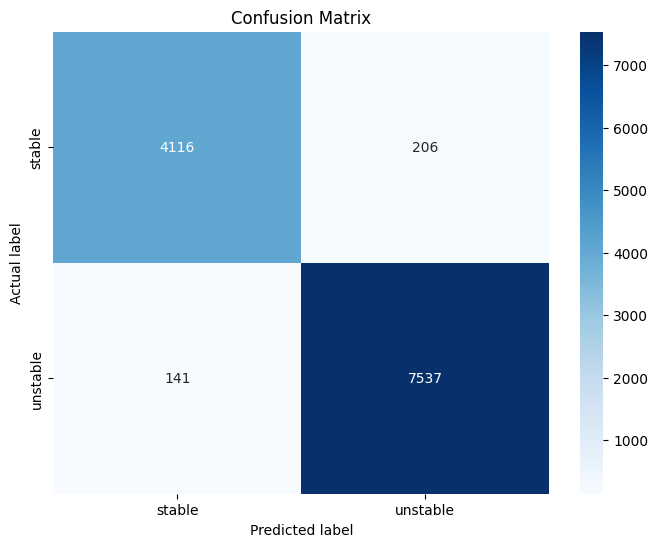

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("/content/smart_grid_stability_augmented.csv")
df['stabf_encoded'] = LabelEncoder().fit_transform(df['stabf'])
X = df.drop(['stabf', 'stabf_encoded', 'stab'], axis=1)
y = df['stabf_encoded']

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the ANN
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)

# Predicting the test set results
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of ANN Model: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["stable", "unstable"]))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["stable", "unstable"], yticklabels=["stable", "unstable"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
pip install keras bayesian-optimization scikit-learn numpy-------------required

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from bayes_opt import BayesianOptimization

# Load dataset
df = pd.read_csv("/content/smart_grid_stability_augmented.csv")
df['stabf_encoded'] = LabelEncoder().fit_transform(df['stabf'])
X = df.drop(['stabf', 'stabf_encoded', 'stab'], axis=1)
y = df['stabf_encoded']

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model(neurons_layer1, neurons_layer2, neurons_layer3, dropout_rate1, dropout_rate2, dropout_rate3):
    model = Sequential([
        Dense(int(neurons_layer1), activation='relu', input_dim=X_train_scaled.shape[1]),
        BatchNormalization(),
        Dropout(float(dropout_rate1)),
        Dense(int(neurons_layer2), activation='relu'),
        BatchNormalization(),
        Dropout(float(dropout_rate2)),
        Dense(int(neurons_layer3), activation='relu'),
        BatchNormalization(),
        Dropout(float(dropout_rate3)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(neurons_layer1, neurons_layer2, neurons_layer3, dropout_rate1, dropout_rate2, dropout_rate3):
    model = create_model(neurons_layer1, neurons_layer2, neurons_layer3, dropout_rate1, dropout_rate2, dropout_rate3)
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, verbose=0)
    _, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    return accuracy

# Define bounds for Bayesian Optimization
pbounds = {
    'neurons_layer1': (32, 128),
    'neurons_layer2': (32, 128),
    'neurons_layer3': (32, 128),
    'dropout_rate1': (0.1, 0.5),
    'dropout_rate2': (0.1, 0.5),
    'dropout_rate3': (0.1, 0.5)
}

optimizer = BayesianOptimization(f=evaluate_model, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=10, n_iter=25)

# Extract the best parameters
best_params = optimizer.max['params']
print("Best parameters found:", best_params)

# Train and evaluate the model with the best parameters found
model = create_model(
    neurons_layer1=best_params['neurons_layer1'],
    neurons_layer2=best_params['neurons_layer2'],
    neurons_layer3=best_params['neurons_layer3'],
    dropout_rate1=best_params['dropout_rate1'],
    dropout_rate2=best_params['dropout_rate2'],
    dropout_rate3=best_params['dropout_rate3']
)
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

# Predict on the test set and calculate metrics
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of ANN Model: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["stable", "unstable"]))


|   iter    |  target   | dropou... | dropou... | dropou... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9477    | 0.2668    | 0.3881    | 0.1       | 61.02     | 46.09     | 40.86     |
| 2         | 0.9467    | 0.1745    | 0.2382    | 0.2587    | 83.73     | 72.24     | 97.78     |
| 3         | 0.9552    | 0.1818    | 0.4512    | 0.111     | 96.36     | 72.06     | 85.63     |
| 4         | 0.9528    | 0.1562    | 0.1792    | 0.4203    | 125.0     | 62.09     | 98.46     |
| 5         | 0.9339    | 0.4506    | 0.4578    | 0.134     | 35.75     | 48.3      | 116.3     |
| 6         | 0.9456    | 0.1393    | 0.2684    | 0.4832    | 83.18     | 98.42     | 62.29     |
| 7         | 0.9523    | 0.3746    | 0.4339    | 0.1073    | 104.0     | 126.9     | 103.8     |
| 8         | 0.9531    | 0.2122    | 0.4157    | 0.1413    | 75.0      | 119.2     | 60.19     |
| 9         | 0.9541

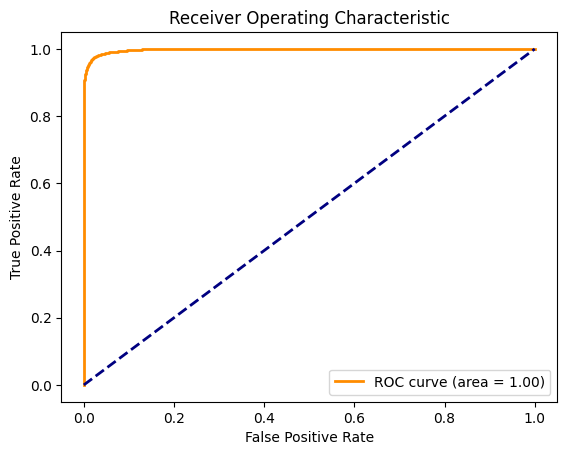

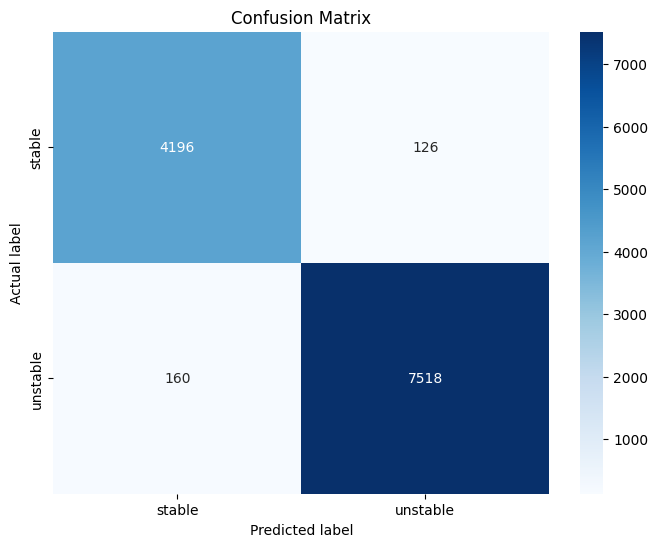

In [ ]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["stable", "unstable"], yticklabels=["stable", "unstable"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()